# This is the script to extract Liver bounding!

In [41]:
import os
import nibabel as nib
len(os.listdir('../../Data/CT_Phase/Task_502_Phase_Data/'))
import SimpleITK as sitk
#len(os.listdir('../../Data/CT_Phase/Full_Image_Liver_07075/'))

In [40]:
import os
import nibabel as nib
import numpy as np
import skimage 
import matplotlib.pyplot as plt
from tqdm import tqdm
import SimpleITK as sitk
import nibabel as nib
import math
#print(os.listdir('../../Test_Data/Test_3D/'))
class ImageLoad:
    def __init__(self,input_path):
        """
        The path should only contain images
        """
        self.input_path = input_path


        #self.images_names = os.listdir('../../Test_Data/Test_3D/')
        self.images_names = os.listdir(self.input_path)
        self.images_num = len(self.images_names)
        self.image_path = [self.input_path + name for name in self.images_names]

    def image_load(self,image_path,reader='nib'):
        if reader == 'nib':
            return nib.load(image_path)
        elif reader == 'sitk':
            return sitk.ReadImage(image_path)
        else:
            raise ValueError("The reader should be either nib or sitk!")
        
    #def image_get_float(self):

  


class LiverBoundingBox:
    def __init__(self,liver_mask,liver_orig,out_path_box=None,file_name=None):
        """
        args:
            liver_mask: the liver mask|nib or sitk
            original_image: the original image|nib or sitk
        """
        self.liver_seg = liver_mask
        self.liver_orig = liver_orig
        self.out_path_box = out_path_box
        self.file_name = file_name
        # self.original_image = original_image
        # self.liver_mask_array = self._get_array(liver_seg)
        # self.original_arrary = self._get_array(original_image)
        # self.image_loader = image_loader
    def extract_liver(self,liver=True):
        """
            get either the liver or tumor region from the mask
            args:
                mask: mask of the liver and tumor
                liver: if True return the liver region, if False return the tumor region
        """
        mask = self._get_array(self.liver_seg)
        mask = mask.astype(int)
        print(mask.shape)
        
        if liver:
            mask[mask == 2] = 1
        else:
            mask[mask == 1] = 0
            mask[mask == 2] = 1
            mask = mask.astype(int)
            
        # only keep the largest connected component
        labeled = skimage.measure.label(mask, connectivity=2)

        labeled[labeled != 1] = 0
      
        mask = labeled
        print(mask.sum())

        return mask


        
    def get_liver_bounding_box(self,liver_mask):
        '''
    Function to generate bounding box for liver, from a binary liver mask
        args:
            liver_mask: binary mask of the liver

        returns:
            bbox: bounding box of the liver (min_row, min_col, min_slice, max_row, max_col, max_slice = bbox)
        '''

        # get the image_probs
        image_probs = skimage.measure.regionprops((liver_mask))

        # get the bounding box of the liver

        if len(image_probs) == 0:
            print(f'[WARNING] no liver found')
            self._recording_failing()
            return None

        ## find the adjacent box that contains the liver
        for props in image_probs:
            bbox = props.bbox
            min_row, min_col, min_slice, max_row, max_col, max_slice = bbox 
            print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)
        return [min_row, min_col, min_slice, max_row, max_col, max_slice]

    def crop_scan(self,liver_bounding):
        """
        Crop the scan with the bounding box
        args:
            liver_bounding: the bounding box of the liver
        """
        liver_original = self._get_array(self.liver_orig)
        # get the bounding box of the liver
        min_row, min_col, min_slice, max_row, max_col, max_slice = list(map(self._check_range,liver_bounding))
        print('this is after check range',min_row, min_col, min_slice, max_row, max_col, max_slice)
        
        #crop the scan
        cropped_scan = liver_original[min_row:max_row,min_col:max_col,min_slice:max_slice]
        return cropped_scan
    
    def store_cropped_data(self,cropped_data):

        if not os.path.exists(self.out_path_box):
            os.mkdir(self.out_path_box)
            print('The path does not exist, create the path!')

        header = self.liver_orig.header
        affine = self.liver_orig.affine
        print("this is shape of cropped data",cropped_data.shape)
        cropped_image = nib.Nifti1Image(cropped_data, affine, header)


        
        nib.save(cropped_image, self.out_path_box + self.file_name)

    @staticmethod   
    def liver_detection(mask):
        if np.count_nonzero(mask) != 0:
            return True


    def _check_range(self,range_num):
        return max(0,range_num)
    
    def _get_array(self,image_file):
        return image_file.get_fdata()
    
    def _recording_failing(self):
        with open(self.out_path_box + 'failing_box.txt','a') as f:
            f.write(self.file_name + '\n')








In [7]:
image_lst = os.listdir('../../Data/CT_Phase/Full_Image_Liver_07075/')
image_liver_slice = {img:() for img in image_lst}

In [19]:
cropped_out_path = '../../Data/CT_Phase/Full_Image_Liver_slice/'
#load the images
image_orig_load = ImageLoad("../../Data/CT_Phase/Full_Image_Liver/")
image_seg_load = ImageLoad("../../Data/CT_Phase/Task_502_Phase_Data/")
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]
    image_orign,image_segg = image_orig_load.image_load(image_orig_load.image_path[i]),image_seg_load.image_load(image_seg_load.image_path[i])

    #finding bounding box
    liver_bbox = LiverBoundingBox(image_segg,image_orign,cropped_out_path,file_name)
    liver_mask = liver_bbox.extract_liver()
    if liver_bbox.liver_detection(liver_mask):
        liver_box_range = liver_bbox.get_liver_bounding_box(liver_mask)
        image_liver_slice[file_name] = liver_box_range
        
    else:
        liver_bbox._recording_failing()

(512, 512, 112)
834018
this is range 61 143 72 330 424 111
(512, 512, 56)
753106
this is range 43 146 19 348 416 54
(512, 512, 37)
204600
this is range 92 176 7 293 383 35
(512, 512, 61)
907715
this is range 94 169 2 416 387 58
(512, 512, 79)
598292
this is range 87 166 42 433 387 77
(512, 512, 59)
226024
this is range 103 178 0 387 368 12
(512, 512, 127)
470047
this is range 101 177 48 380 372 79
(512, 512, 48)
951642
this is range 46 140 5 387 419 43
(512, 512, 42)
789539
this is range 30 143 0 376 400 36
(512, 512, 48)
890230
this is range 40 176 5 387 414 43
(512, 512, 34)
492336
this is range 44 133 1 319 374 32
(512, 512, 60)
570101
this is range 27 114 0 341 384 15
(512, 512, 113)
2087630
this is range 43 127 6 332 376 108
(512, 512, 125)
657710
this is range 43 125 49 328 374 80
(512, 512, 142)
783531
this is range 60 144 85 325 386 140
(512, 512, 65)
741745
this is range 62 142 8 321 384 62
(512, 512, 142)
776687
this is range 59 140 86 322 383 141
(512, 512, 38)
447880
this i

In [20]:
with open ('../../Data/CT_Phase/Liver_slice_info.txt','w') as f:
    for slice in image_liver_slice:
        f.write(slice + ' ' + str(image_liver_slice[slice]) + '\n')

In [26]:
img_1_rs = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz').get_fdata()
img_1_rs.shape

img_1_orig = nib.load('../../Data/CT_Phase/Full_Image_Liver/CILM_CT_101040_0000.nii.gz').get_fdata()
img_1_orig.shape

img_1_seg = nib.load('../../Data/CT_Phase/Task_502_Phase_Data/CILM_CT_101040.nii.gz').get_fdata()
img_1_seg.shape

img_1_liver = nib.load('../../Data/CT_Phase/Full_image_Liver_slice_07075_window/CILM_CT_101040_0000.nii.gz').get_fdata()
img_1_liver.shape

(512, 512, 55)

In [9]:
def save_liver_slice(image_path,image_name,cropped_out_path,slice_margin=0):
    """
    args:
        image_path: the path of the image
        image_name: the name of the image
        slice_margin: the margin of the slice
    """
    image = nib.load(image_path)
    image_data = image.get_fdata()
    image_shape = image_data.shape
    print(image_shape,666)
    min_row, min_col, min_slice, max_row, max_col, max_slice = image_liver_slice[image_name]
    print('min and max slice',min_slice,max_slice)
    min_slice = max(0,math.floor(min_slice - min_slice*slice_margin))
    print('fucking max slice',max_slice)
    max_slice = min(image_shape[2],math.ceil(max_slice + max_slice* slice_margin))
    print("fucking after",max_slice)
    print(min_slice,max_slice)
    image_data = image_data[:,:,min_slice:max_slice]
    print(image_data.shape)
    image = nib.Nifti1Image(image_data, image.affine, image.header)
    nib.save(image, cropped_out_path + '/' + image_name)
    print('saved!')

In [18]:
image_orign = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz')
image_orign.shape

(521, 521, 112)

263

In [38]:
import matplotlib.pyplot as plt
image_path = '../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_176841_0000.nii.gz'
image_name = 'CILM_CT_176841_0000.nii.gz'
cropped_out_path = '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

os.makedirs(cropped_out_path,exist_ok=True)
save_liver_slice(image_path,image_name,cropped_out_path,slice_margin=0.5)



(539, 539, 85) 666
min and max slice 333 528
fucking max slice 528
fucking after 85
166 85
(539, 539, 0)
saved!


In [ ]:

#save all slice that includes liver,full image not resample!
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)



In [34]:
image_orig_load = ImageLoad("../../Data/CT_Phase/Full_Image_Liver_07075/")
os.mkdir('../../Data/CT_Phase/Full_image_Liver_slice_07075/')
cropped_out_path = '../../Data/CT_Phase/Full_Image_Liver_slice_07075/'

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

In [37]:
img = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_176841_0000.nii.gz').get_fdata()
img.shape

(539, 539, 85)

In [ ]:
#resample slice includes liver
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)

# Flip

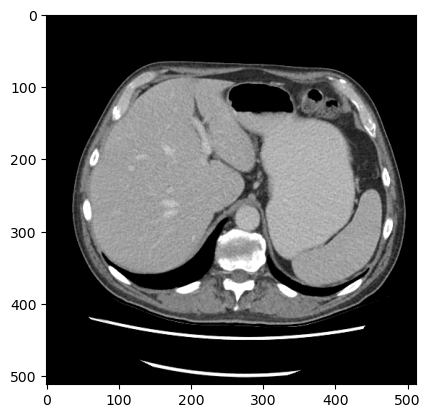

In [57]:
import matplotlib.pyplot as plt
img = sitk.ReadImage('../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed/CILM_CT_101040_0000.nii.gz')
img_arrary = sitk.GetArrayFromImage(img)

flip_img = sitk.Flip(img,[False,True,False])


#save flipped image

img = sitk.ReadImage('../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed/CILM_CT_101040_0000.nii.gz')


In [66]:
image_orig_load = ImageLoad("../../Data/CT_Phase/Full_image_Liver_slice/")
cropped_out_path = '../../Data/CT_Phase/Full_image_Liver_slice/'


for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    img_sitk = sitk.ReadImage(image_path)
    flip_img = sitk.Flip(img_sitk,[False,True,False])
    sitk.WriteImage(flip_img,cropped_out_path + file_name)

100%|██████████| 263/263 [08:25<00:00,  1.92s/it]


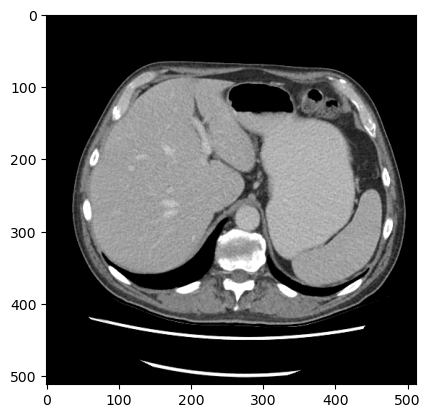

In [65]:
img_window = os.listdir('../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed/')

for img in tqdm(img_window[0:30]):
    img_path = '../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed/' + img
    img_name = img
    img_array = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
    #for each slice save as png
    for i in range(img_array.shape[0]):
        plt.imsave('../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed_png/' + img_name + '_' + str(i) + '.png',img_array[i,:,:],cmap='gray')